In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
import sys
from data import dataset
sys.path.insert(0, '/home/andrea/Scrivania/Tesi/leonardo')


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [3]:
with open("/home/andrea/Scrivania/Tesi/leonardo/config_env.yaml", 'r') as f:
    config_env = yaml.safe_load(f)
id_model = "GCN_LSTMseq2seq"
with open(os.path.join(config_env['paths']['config'], f"{id_model}.yaml"), 'r') as f:
    config = yaml.safe_load(f)
    
config.update(config_env)

if 'epochs' in config_env['setting'].keys():
    config['training']['epochs'] = config_env['setting']['epochs']
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']
PATH = os.path.join(config['paths']['data'], config['setting']['dataset'], f"{past_step}_{future_step}.pkl")

if os.path.exists(PATH):
    with open(PATH, "rb") as f:
        ds = pickle.load(f)
        
len_train = int(len(ds)*0.75)
len_val = len(ds)-len_train
batch_size = 14
len_train = int(len(ds)*config['dataset']['train_split'])
len_val = int(len(ds)*config['dataset']['val_split'])
len_test = len(ds)-(len_train+len_val)
df_train, df_val, df_test = torch.utils.data.random_split(dataset=ds, lengths = [len_train, len_val, len_test])
dl_train = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(dataset=df_test, batch_size=batch_size, shuffle=True)
x_past, x_fut, y, adj = next(iter(dl_train))
config['setting']['in_feat_past'] = x_past.shape[-1]
config['setting']['in_feat_future'] = x_fut.shape[-1]
print(x_past.shape)
print(x_fut.shape)
print(y.shape)

torch.Size([14, 30, 107, 21])
torch.Size([14, 50, 107, 7])
torch.Size([14, 107, 50])


In [4]:
from models.GAT_LSTMseq2seq.model import GAT_LSTMseq2seq
from models.GCN_LSTMseq2seq.model import GCN_LSTMseq2seq

In [5]:
device = torch.device("cpu")       
model = GCN_LSTMseq2seq(in_feat_past = config['setting']['in_feat_past'],
                            in_feat_fut = config['setting']['in_feat_future'],
                            past = past_step,
                            future = future_step,
                            dropout = config['model']['dropout'], 
                            num_layer_gnn_past = config['model']['num_layer_gnn_past'],
                            num_layer_gnn_future = config['model']['num_layer_gnn_future'],
                            categorical_past = config['categorical'][config['setting']['dataset']]['past'],
                            categorical_future = config['categorical'][config['setting']['dataset']]['future'],
                            device = device).to(device)
model.load_state_dict(torch.load(os.path.join(config['paths']['models'], f'GCN_LSTMseq2seq_{past_step}_{future_step}.pt')))
model(x_past, x_fut, adj[0]).shape

torch.Size([14, 107, 50])

In [6]:
def step(model, 
         dataloader: DataLoader)-> pd.DataFrame:
    
    # put model in evaluation mode
    model.eval()
    yh = []
    real = []
    with torch.no_grad():
        for x_past, x_fut, y, adj in tqdm(iter(dataloader)):
            yh.append(model(x_past.to(model.device).float(), x_fut.to(model.device).float(), adj[0].to(model.device).float()).cpu().detach())
            real.append(y)
    yh = torch.cat(yh)
    real = torch.cat(real)
    return yh, real

In [7]:
yh, real = step(model, dl_test)
res = yh-real

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:32<00:00,  1.78s/it]


In [ ]:
px.histogram(res[:,:3,:].transpose(0,1).flatten(1),
             marginal="box",
             width = 1000, 
             height = 700, 
             title="Distribuzione dell'errore per ogni nodo")

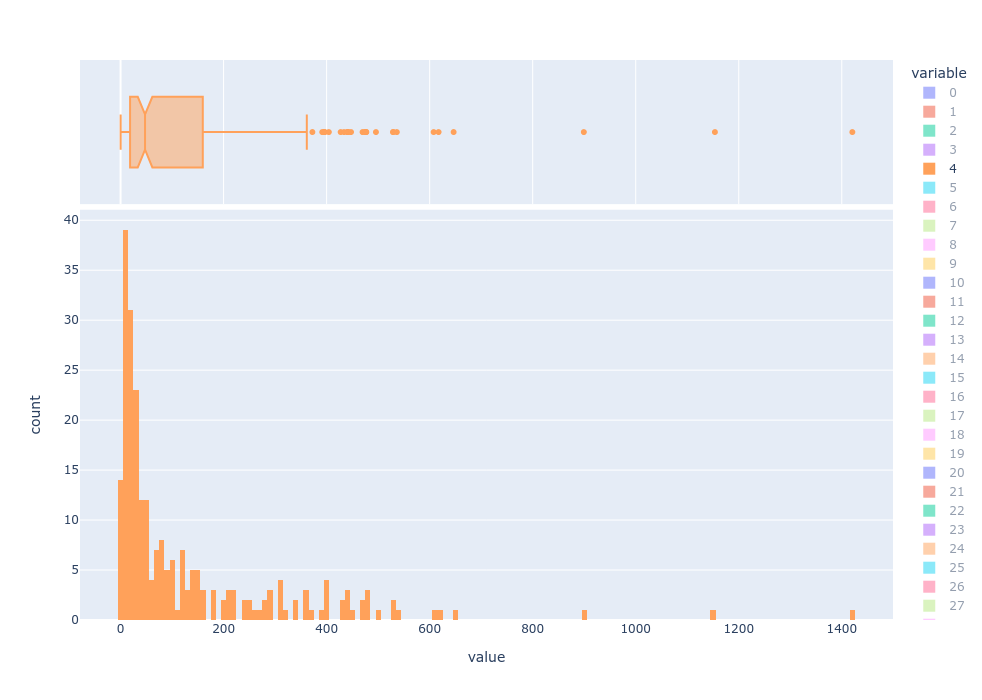

In [45]:
px.histogram(torch.abs(res[:,0,:]),
             marginal="box",
             width = 1000, 
             height = 700)

In [53]:
res.shape

torch.Size([244, 107, 50])

In [52]:
torch.mean(res[:,:,:], 1).shape

torch.Size([244, 50])

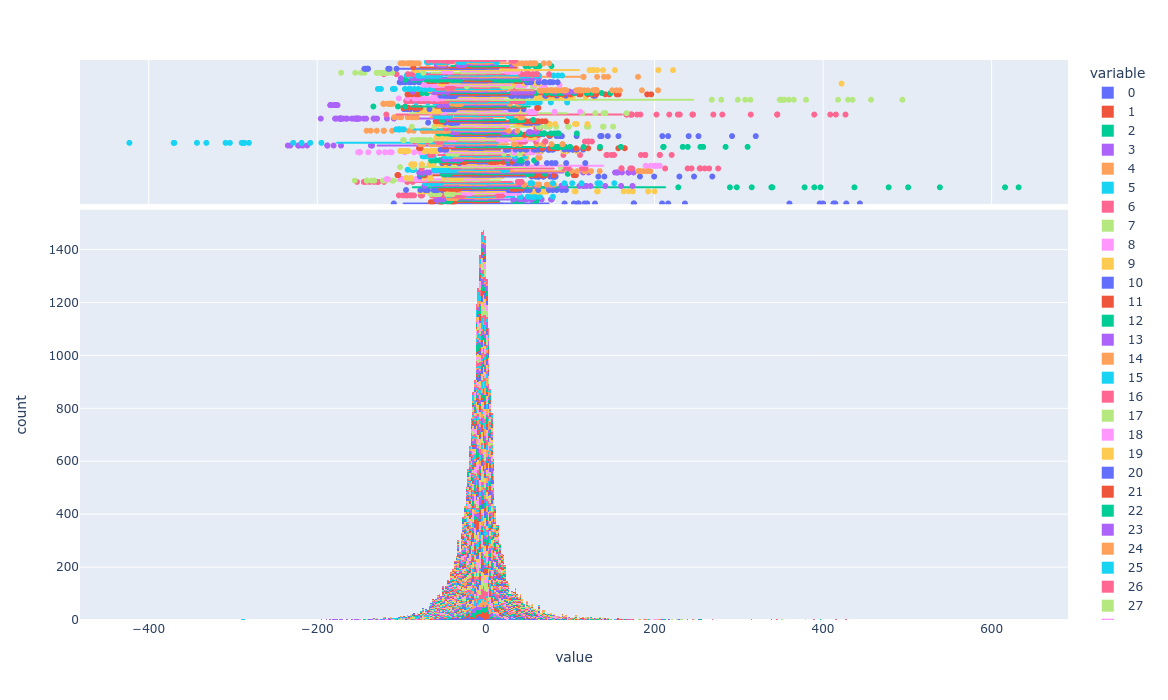

In [48]:
px.histogram(torch.mean(res[:,:,:].transpose(-1,-2), 1),
             marginal="box", 
             width = 1000, 
                    height = 700, 
            title="")